# Preprocessing data from 10X Genomics (E18 Mouse Brain and PBMC Human)

The following notebook is meant ot be run parametrized through papermill, or directly by changing variable res_name to be "PBMC" or "MSB". Please download the data from the links below prior to running. 

Note that:

- for Mouse Brain (MSB): the single-nucleus dataset does not have a filtered option, so we'll filter ourselves.
- for PBMC: the filtered options are only available for the single-cell for pseudobulks and the single-nucleus for reference. The other dataset does not have a filtered option, so we'll filter ourselves.

## Mouse (MSB) data downloaded from:

[Single-Nucleus for Reference](https://www.10xgenomics.com/datasets/5-k-mouse-e-18-combined-cortex-hippocampus-and-subventricular-zone-nuclei-3-1-standard-6-0-0) (Gene Expression - Feature / cell matrix (per-sample)), 
[Single-Cell for Reference](https://www.10xgenomics.com/datasets/9-k-brain-cells-from-an-e-18-mouse-2-standard-2-0-1) (Gene / cell matrix (filtered)), 
[Single-Cell for Pseudo-bulks](https://www.10xgenomics.com/datasets/10-k-brain-cells-from-an-e-18-mouse-v-3-chemistry-3-standard-3-0-0) (Feature / cell matrix (filtered))

## PBMC data downloaded from:

[Single-Nucleus for Reference](https://www.10xgenomics.com/datasets/10-k-human-pbm-cs-multiome-v-1-0-chromium-x-1-standard-2-0-0) (Filtered feature barcode matrix (HDF5)), 
[Single-Cell for Reference](https://www.10xgenomics.com/datasets/10-k-human-pbm-cs-5-v-2-0-chromium-x-2-standard-6-1-0) (Gene Expression - Feature / cell matrix HDF5 (per-sample)), 
[Single-Cell for Pseudo-bulks](https://www.10xgenomics.com/datasets/8-k-pbm-cs-from-a-healthy-donor-2-standard-2-1-0) (Gene / cell matrix (filtered))

In [1]:
# Import required libraries
import scanpy as sc
import anndata as ad
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.sparse import issparse
import celltypist
from celltypist import models
import os
from anndata import AnnData, read_h5ad
from pathlib import Path

In [2]:
res_name = "MSB"

In [3]:
# Parameters
res_name = "PBMC"


In [4]:
# Set scanpy settings
sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=100, facecolor="white")

base_path = f"{os.getcwd()}/../data/{res_name}/"

scanpy==1.10.4 anndata==0.11.3 umap==0.5.7 numpy==2.1.3 scipy==1.15.2 pandas==2.2.2 scikit-learn==1.6.1 statsmodels==0.14.4 igraph==0.11.8 pynndescent==0.5.13


In [5]:
if res_name == "MSB":
    # Paths to the downloaded datasets
    sc_ref_path = f"{base_path}/filtered_gene_bc_matrices/mm10/"
    sc_bulk_path = f"{base_path}/filtered_feature_bc_matrix/"
    sn_path = f"{base_path}/sample_feature_bc_matrix/"

    # Load SC pseudo-bulk dataset
    adata_sc_bulk = sc.read_10x_mtx(sc_bulk_path, var_names="gene_symbols")

    # Load SC reference dataset
    adata_sc_ref = sc.read_10x_mtx(sc_ref_path, var_names="gene_symbols")

    # Load SN reference dataset
    adata_sn = sc.read_10x_mtx(sn_path, var_names="gene_symbols")

    # Model for cell assignment
    model_cell = "Developing_Mouse_Brain.pkl"
    # to identify mitochondrial genes
    myto_str = "mt-"

    # Comprehensive mapping of original cell types to grouped categories
    cell_type_mapping = {
        "Neuron: Cortical or hippocampal glutamatergic": "Excitatory Neurons",
        "Neuron: Forebrain GABAergic": "Inhibitory Neurons",
        "Neuroblast: Neuronal intermediate progenitor": "Neuronal Progenitors",
        "Neuroblast: Forebrain glutamatergic": "Neuronal Progenitors",
        "Neuroblast: Forebrain GABAergic": "Neuronal Progenitors",
        "Neuron: Cajal-Retzius": "Excitatory Neurons",
        "Glioblast: Forebrain": "Glial Cells",
        "Glioblast: Forebrain astrocyte": "Glial Cells",
        "Glioblast: Mixed region astrocytes": "Glial Cells",
        "Glioblast: Mixed region": "Glial Cells",
        "Glioblast: PreOPC": "Glial Cells",
        "Radial glia: Dorsal forebrain": "Glial Cells",
        "Radial glia: Cortical hem": "Glial Cells",
        "Oligodendrocyte: Oligodendrocyte precursor cell": "Glial Cells",
        "Vascular: Endothelial": "Vascular Cells",
        "Vascular: Pericyte": "Vascular Cells",
        "Blood: Erythrocyte": "Erythrocyte",
        "Immune: Non-cycling microglia": "Microglia",
    }

elif res_name == "PBMC":
    # Paths to the downloaded datasets
    sc_bulk_path = f"{base_path}/filtered_gene_bc_matrices/GRCh38/"
    sc_ref_path = f"{base_path}/10k_PBMC_5pv2_nextgem_Chromium_X_10k_PBMC_5pv2_nextgem_Chromium_X_count_sample_feature_bc_matrix.h5"
    sn_path = f"{base_path}/10k_PBMC_Multiome_nextgem_Chromium_X_filtered_feature_bc_matrix.h5"

    # Load SC pseudo-bulk dataset
    adata_sc_bulk = sc.read_10x_mtx(sc_bulk_path, var_names="gene_symbols")

    # Load SC reference dataset
    adata_sc_ref = sc.read_10x_h5(sc_ref_path)

    # Load SN reference dataset
    adata_sn = sc.read_10x_h5(sn_path)

    model_cell = "Adult_COVID19_PBMC.pkl"  # says covid but includes healthy controls.
    # to identify mitochondrial genes
    myto_str = "MT-"

    cell_type_mapping = {
        "CD4n T": "CD4 T Cells",
        "CD4m T": "CD4 T Cells",
        "CD8m T": "CD8 T Cells",
        "gd T": "Gamma Delta T Cells",
        "NK": "Natural Killer Cells",
        "B": "B Cells",
        "IgA PB": "Plasmablasts",
        "CD14 Monocyte": "CD14 Monocytes",
        "CD16 Monocyte": "CD16 Monocytes",
        "DC": "Dendritic Cells",
        "pDC": "Dendritic Cells",
        "SC & Eosinophil": "SC & Eosinophil",
        "Platelet": "Platelets",
    }
else:
    ValueError(f'Not a valid res_name. Choose "MSB"" or "PBMC", you choose {res_name}')

--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


reading /projects/aivich@xsede.org/deconvolution_sc_sn_comparison/notebooks/../data/PBMC//10k_PBMC_5pv2_nextgem_Chromium_X_10k_PBMC_5pv2_nextgem_Chromium_X_count_sample_feature_bc_matrix.h5


 (0:00:00)


reading /projects/aivich@xsede.org/deconvolution_sc_sn_comparison/notebooks/../data/PBMC//10k_PBMC_Multiome_nextgem_Chromium_X_filtered_feature_bc_matrix.h5


 (0:00:04)


In [6]:
# Display dataset shapes
print(
    f"SC Bulk: {adata_sc_bulk.shape}, SC Ref: {adata_sc_ref.shape}, SN: {adata_sn.shape}"
)

# Make unique gene names
adata_sc_bulk.var_names_make_unique()
adata_sc_ref.var_names_make_unique()
adata_sn.var_names_make_unique()

# Quick QC summary
adata_list = [adata_sc_bulk, adata_sc_ref, adata_sn]
for i, adata in enumerate(adata_list):
    print(f"Dataset {i+1}: {adata.shape} cells x genes")

# View raw counts matrix to check for any abnormalities/normalizations
adata_sc_bulk.X[:5, :5]

SC Bulk: (8381, 33694), SC Ref: (9391, 36601), SN: (10970, 36601)
Dataset 1: (8381, 33694) cells x genes
Dataset 2: (9391, 36601) cells x genes
Dataset 3: (10970, 36601) cells x genes


<Compressed Sparse Column sparse matrix of dtype 'float32'
	with 0 stored elements and shape (5, 5)>

In [7]:
# Compute basic QC metrics
for adata in adata_list:
    adata.var["mt"] = adata.var_names.str.startswith(myto_str)  # Mitochondrial genes
    sc.pp.calculate_qc_metrics(
        adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
    )

## Plot QC metrics and filter accordingly

In [8]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor="white")

scanpy==1.10.4 anndata==0.11.3 umap==0.5.7 numpy==2.1.3 scipy==1.15.2 pandas==2.2.2 scikit-learn==1.6.1 statsmodels==0.14.4 igraph==0.11.8 pynndescent==0.5.13


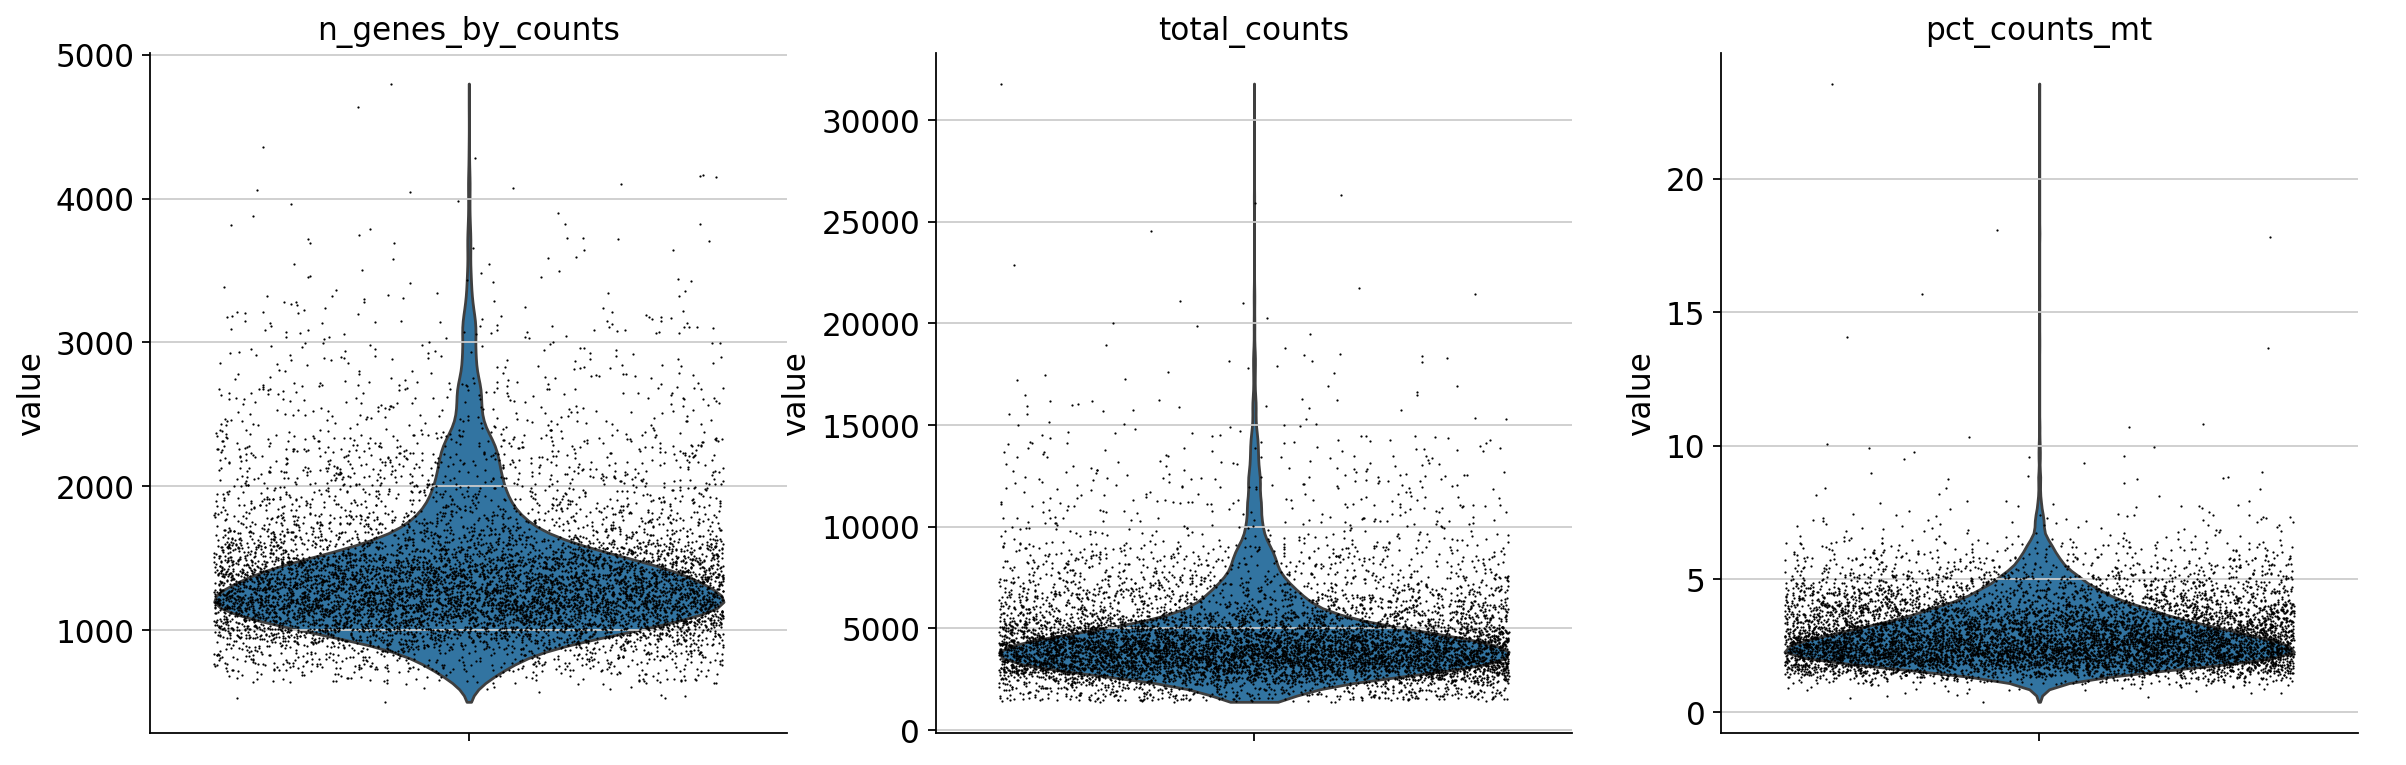

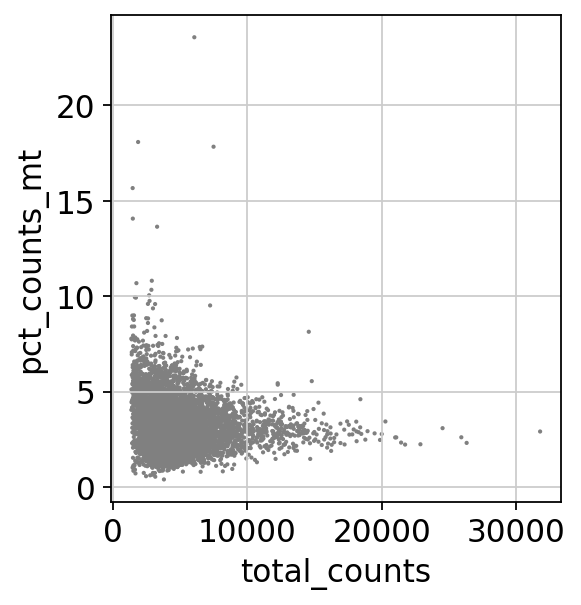

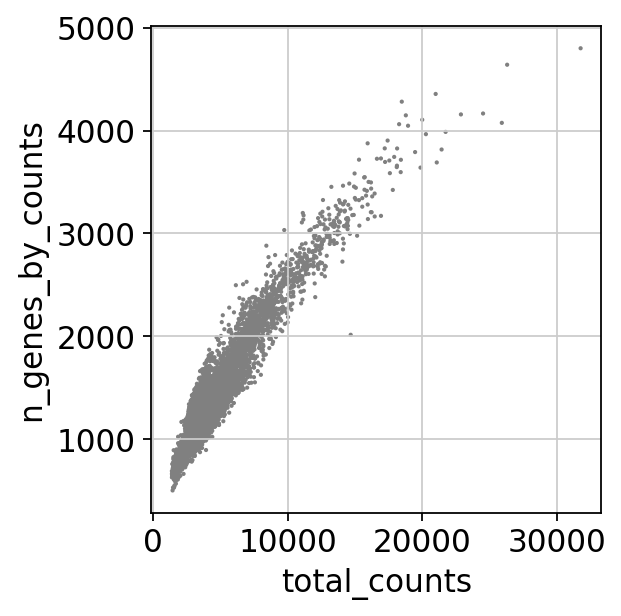

In [9]:
sc.pl.violin(
    adata_sc_bulk,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)
sc.pl.scatter(adata_sc_bulk, x="total_counts", y="pct_counts_mt")
sc.pl.scatter(adata_sc_bulk, x="total_counts", y="n_genes_by_counts")

... storing 'feature_types' as categorical


... storing 'genome' as categorical


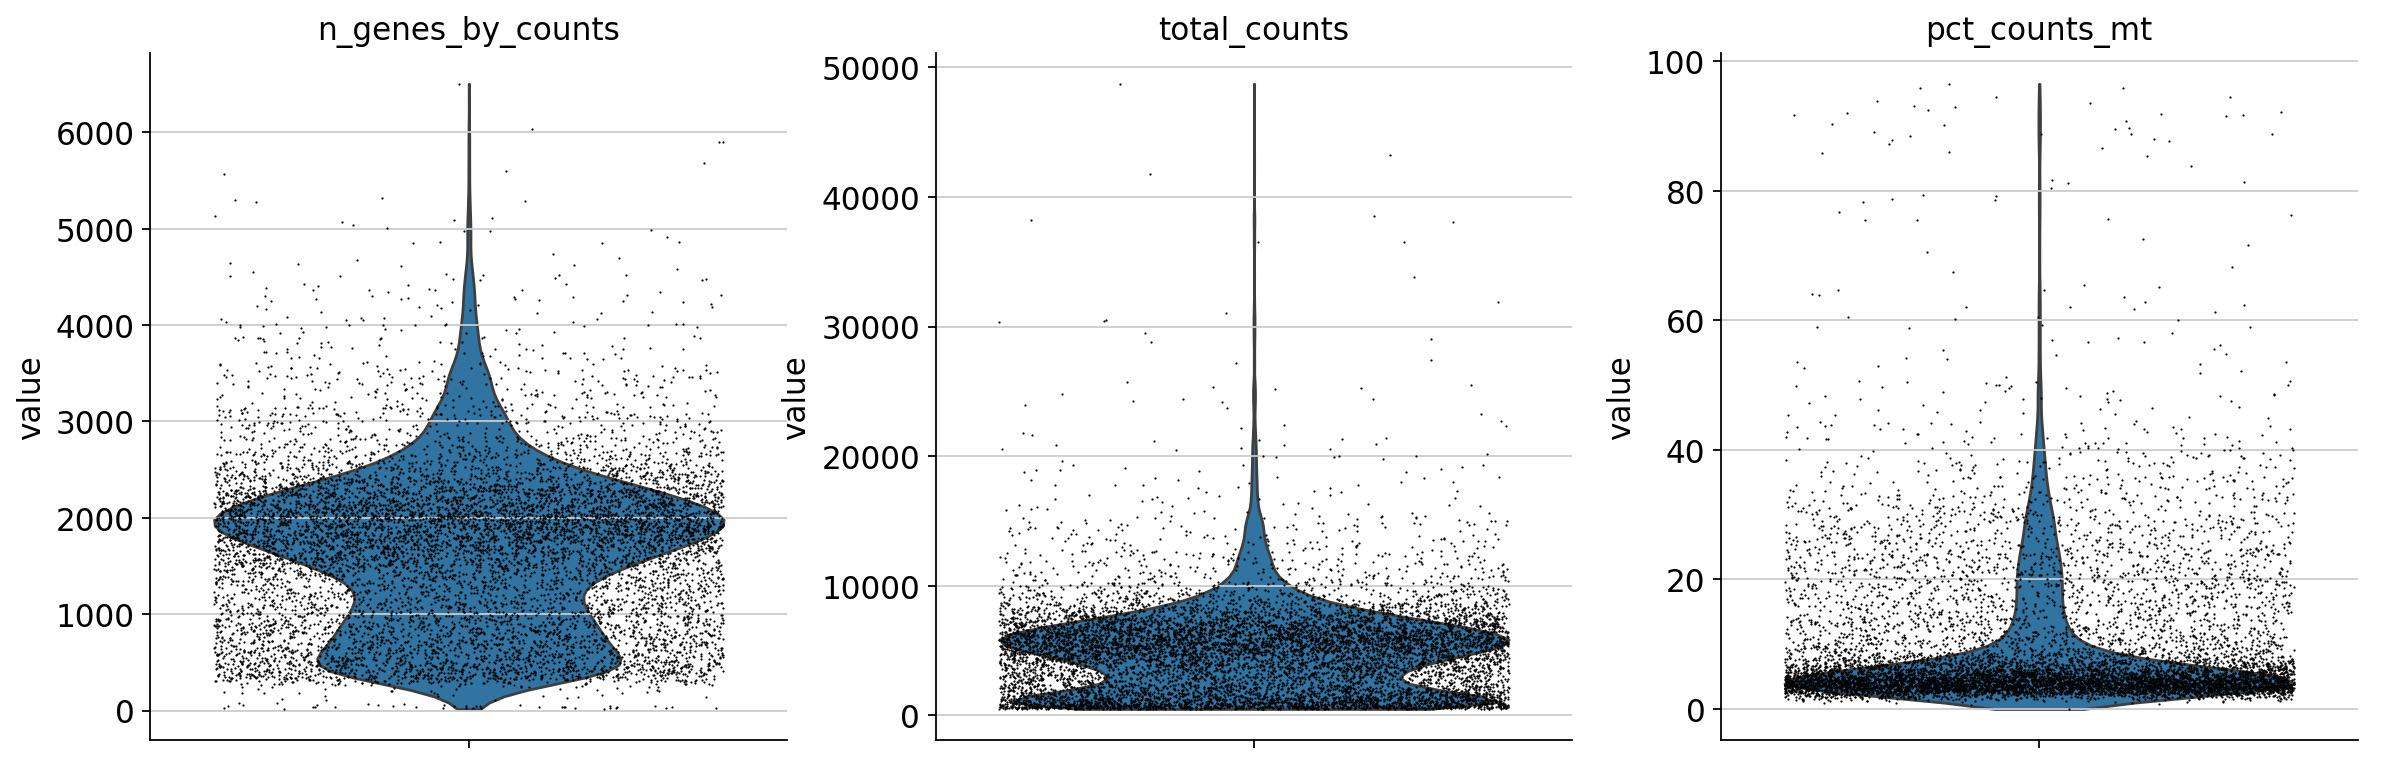

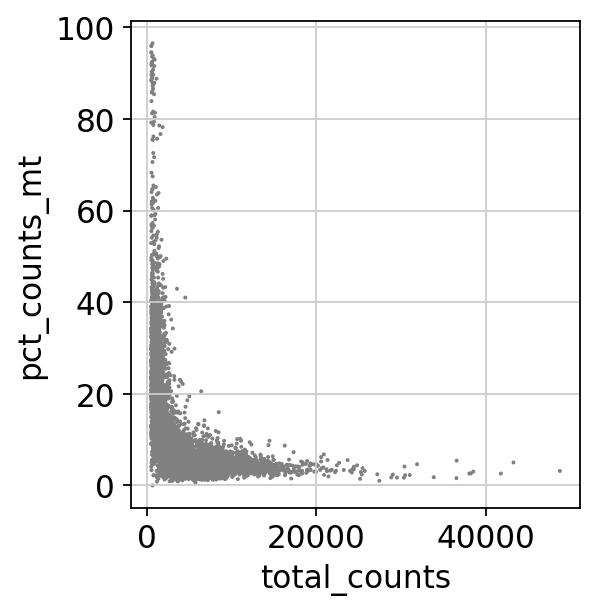

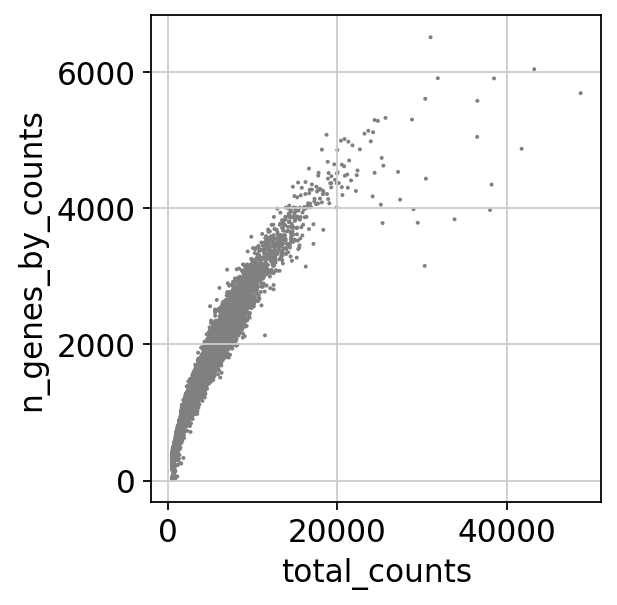

In [10]:
sc.pl.violin(
    adata_sc_ref,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)
sc.pl.scatter(adata_sc_ref, x="total_counts", y="pct_counts_mt")
sc.pl.scatter(adata_sc_ref, x="total_counts", y="n_genes_by_counts")

... storing 'feature_types' as categorical


... storing 'genome' as categorical


... storing 'interval' as categorical


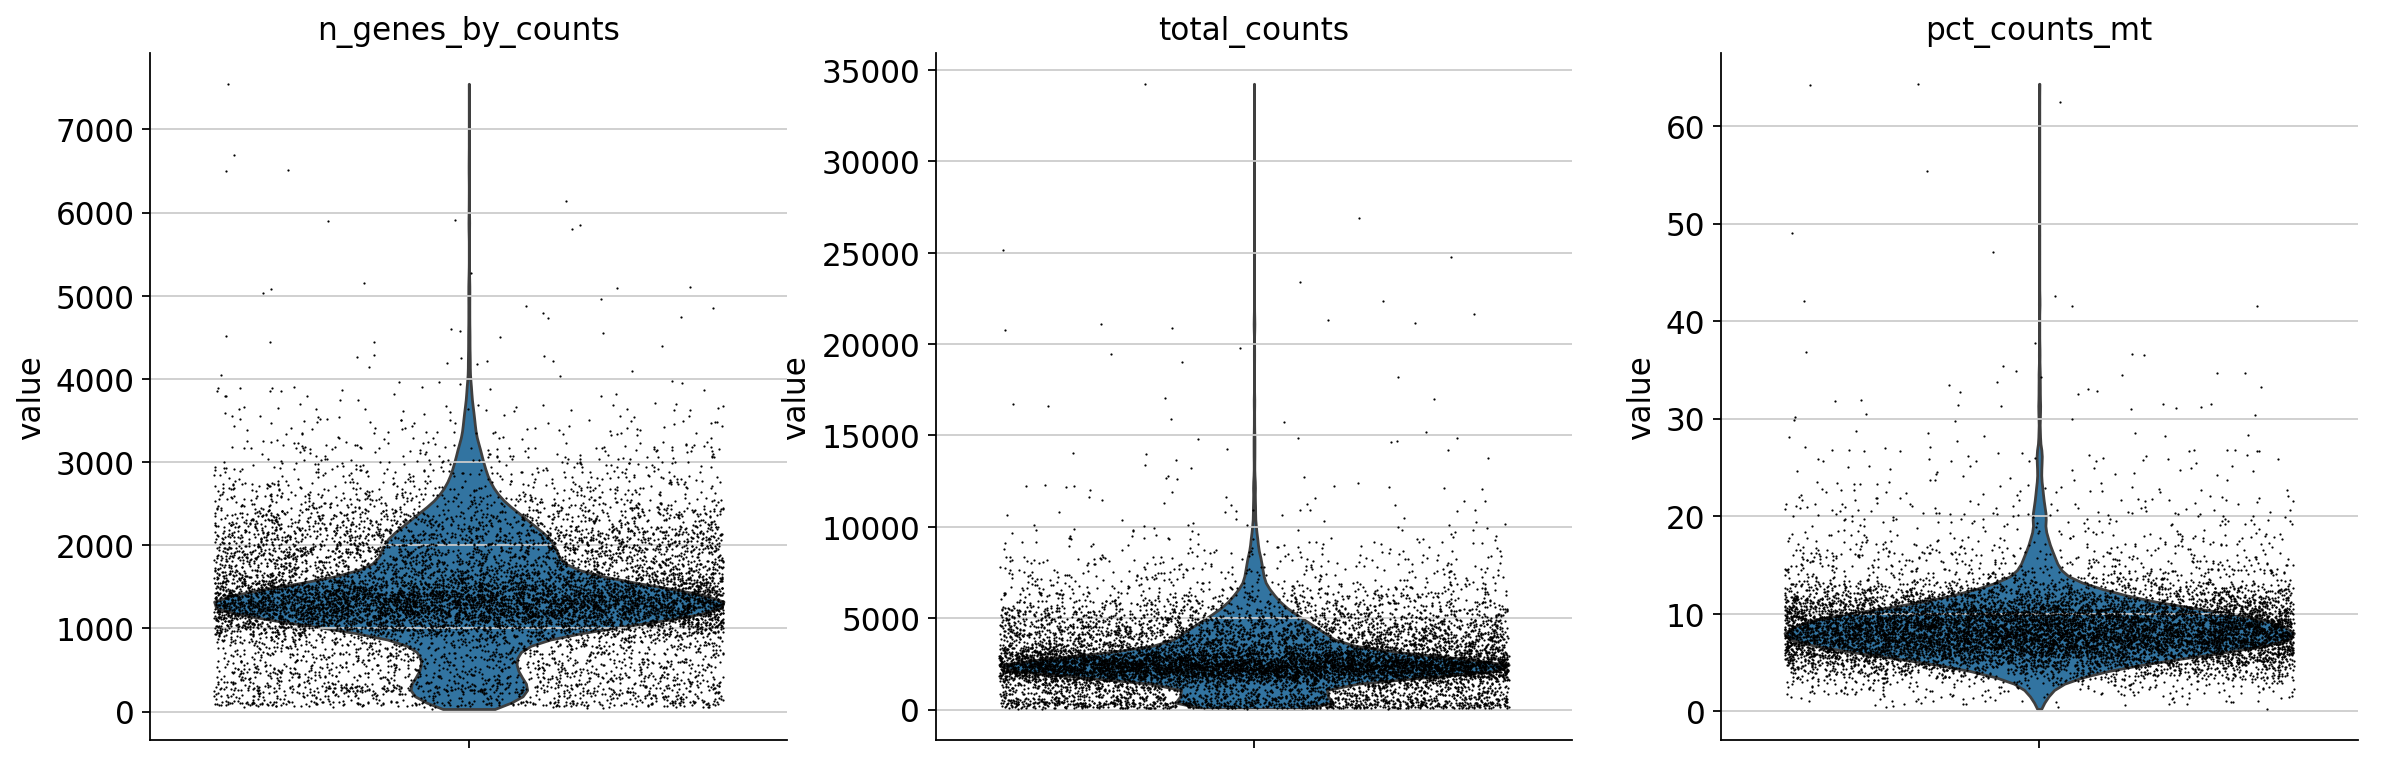

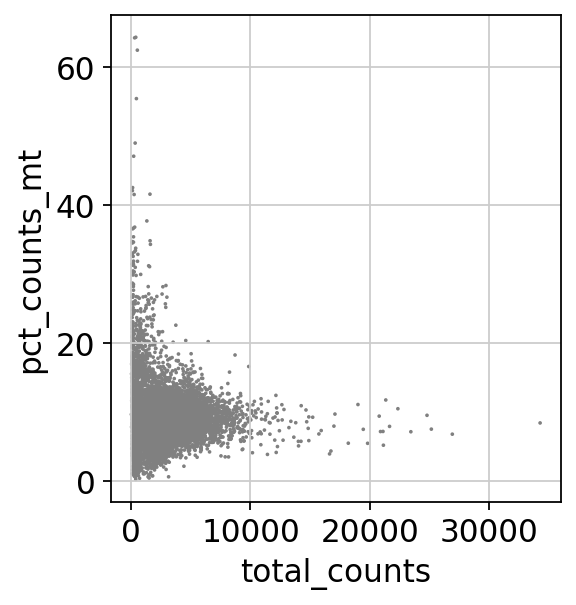

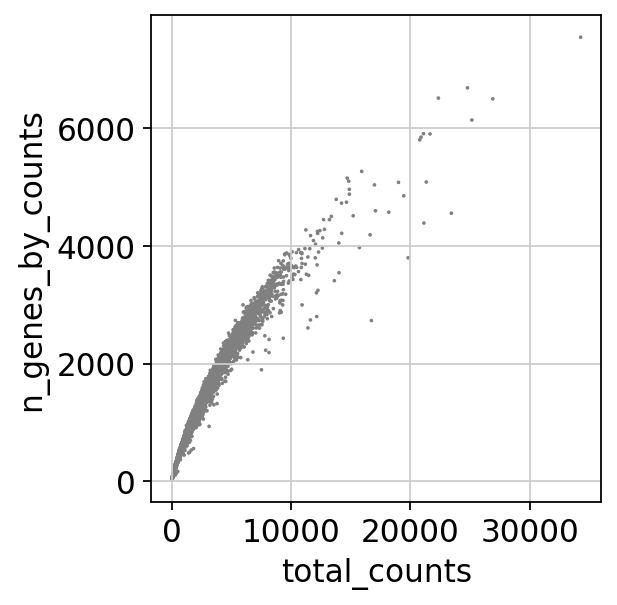

In [11]:
sc.pl.violin(
    adata_sn,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)
sc.pl.scatter(adata_sn, x="total_counts", y="pct_counts_mt")
sc.pl.scatter(adata_sn, x="total_counts", y="n_genes_by_counts")

We'll filter the datasets as needed after!

## Dimensionality Reduction (PCA & UMAP and clustering)

In [12]:
for adata in adata_list:
    adata.raw = adata.copy()

In [13]:
# Normalize each dataset
for adata in adata_list:
    sc.pp.normalize_total(adata, target_sum=1e4)  # Normalize total read counts per cell
    sc.pp.log1p(adata)  # Log transformation

normalizing counts per cell


    finished (0:00:00)


normalizing counts per cell


    finished (0:00:00)


normalizing counts per cell


    finished (0:00:00)


In [14]:
for adata in adata_list:
    sc.pp.highly_variable_genes(adata, n_top_genes=2000)
    sc.pp.pca(adata)
    sc.pp.neighbors(adata)
    sc.tl.umap(adata)

extracting highly variable genes


    finished (0:00:00)


--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


computing PCA


    with n_comps=50


    finished (0:00:00)


computing neighbors


    using 'X_pca' with n_pcs = 50


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:31)


computing UMAP


    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:15)


extracting highly variable genes


    finished (0:00:00)


--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


computing PCA


    with n_comps=50


    finished (0:00:00)


computing neighbors


    using 'X_pca' with n_pcs = 50


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)


computing UMAP


    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:17)


extracting highly variable genes


    finished (0:00:00)


--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


computing PCA


    with n_comps=50


    finished (0:00:00)


computing neighbors


    using 'X_pca' with n_pcs = 50


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)


computing UMAP


    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:07)


running Leiden clustering


    finished: found 12 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


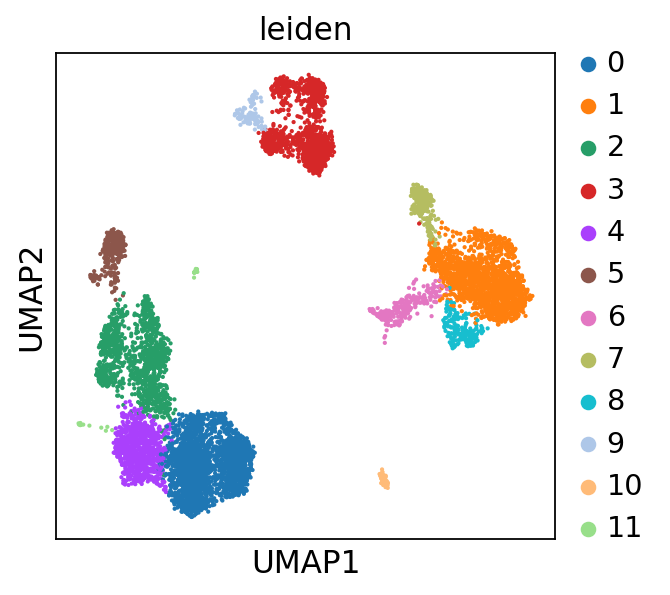

running Leiden clustering


    finished: found 12 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


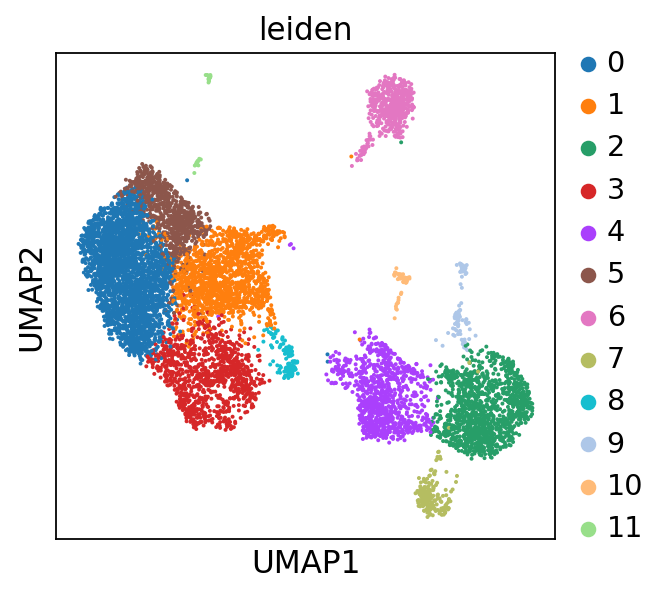

running Leiden clustering


    finished: found 10 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


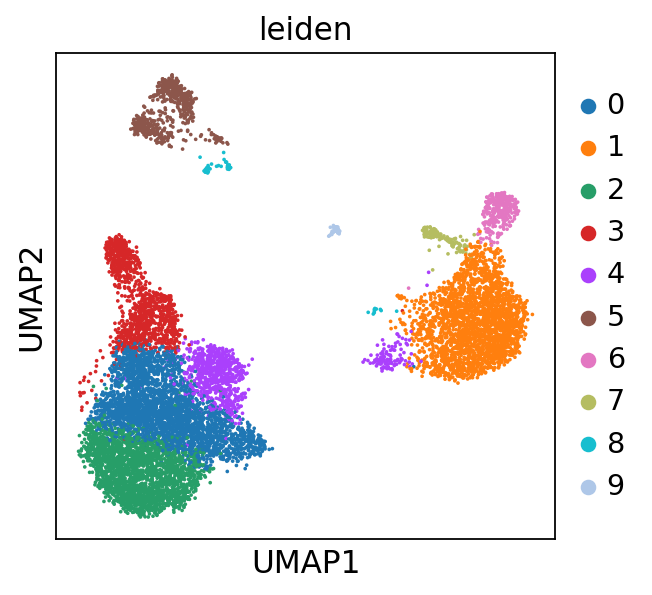

In [15]:
for adata in adata_list:
    sc.tl.leiden(adata, resolution=0.5)  # Louvain clustering
    sc.pl.umap(adata, color="leiden")

## Assigning with celltypist, following this [tutorial](https://colab.research.google.com/github/Teichlab/celltypist/blob/main/docs/notebook/celltypist_tutorial.ipynb#scrollTo=premier-measurement)

In [16]:
models.models_path = base_path
models.download_models(
    model=model_cell, force_update=True
)  # Enabling `force_update = True` will overwrite existing (old) models.
models.models_description()

📜 Retrieving model list from server https://celltypist.cog.sanger.ac.uk/models/models.json


📚 Total models in list: 58


📂 Storing models in /projects/aivich@xsede.org/deconvolution_sc_sn_comparison/notebooks/../data/PBMC/


💾 Total models to download: 1


💾 Downloading model [1/1]: Adult_COVID19_PBMC.pkl


👉 Detailed model information can be found at `https://www.celltypist.org/models`


,model,description
0,Immune_All_Low.pkl,immune sub-populations combined from 20 tissue...
1,Immune_All_High.pkl,immune populations combined from 20 tissues of...
2,Adult_COVID19_PBMC.pkl,peripheral blood mononuclear cell types from C...
3,Adult_CynomolgusMacaque_Hippocampus.pkl,cell types from the hippocampus of adult cynom...
4,Adult_Human_MTG.pkl,cell types and subtypes (10x-based) from the a...
5,Adult_Human_PancreaticIslet.pkl,cell types from pancreatic islets of healthy a...
6,Adult_Human_PrefrontalCortex.pkl,cell types and subtypes from the adult human d...
7,Adult_Human_Skin.pkl,cell types from human healthy adult skin
8,Adult_Human_Vascular.pkl,vascular populations combined from multiple ad...
9,Adult_Mouse_Gut.pkl,cell types in the adult mouse gut combined fro...


In [17]:
# Load model and predict
predictions_sn = celltypist.annotate(adata_sn, model=model_cell, majority_voting=True)
predictions_sn.predicted_labels.majority_voting.value_counts()

🔬 Input data has 10970 cells and 36601 genes


🔗 Matching reference genes in the model


🧬 3017 features used for prediction


⚖️ Scaling input data


🖋️ Predicting labels


✅ Prediction done!


👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it


⛓️ Over-clustering input data with resolution set to 10


running Leiden clustering


    finished: found 184 clusters and added
    'over_clustering', the cluster labels (adata.obs, categorical) (0:00:00)


🗳️ Majority voting the predictions


✅ Majority voting done!


majority_voting
CD4n T           2820
CD14 Monocyte    2682
CD4m T           1975
CD8m T           1897
B                 565
NK                474
CD16 Monocyte     254
gd T              148
DC                 71
pDC                46
IgA PB             38
Name: count, dtype: int64

In [18]:
# Get an `AnnData` with predicted labels embedded into the cell metadata columns.
predictions_sn.predicted_labels
adata_sn = predictions_sn.to_adata()
adata_sn.obs["cell_types"] = adata_sn.obs["predicted_labels"]
adata_sn.obs

,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,leiden,predicted_labels,over_clustering,majority_voting,conf_score,cell_types
AAACAGCCAACAACAA-1,1579,2890.0,428.0,14.809689,1,CD14 Monocyte,0,CD14 Monocyte,0.996423,CD14 Monocyte
AAACAGCCACCGGCTA-1,1368,2373.0,178.0,7.501054,3,NK,1,NK,1.000000,NK
AAACAGCCAGGACACA-1,728,1116.0,119.0,10.663082,4,CD8m T,2,CD8m T,0.000189,CD8m T
AAACAGCCATCCTAGA-1,2068,4518.0,492.0,10.889774,1,CD14 Monocyte,7,CD14 Monocyte,0.853037,CD14 Monocyte
AAACATGCAAAGGTAC-1,1813,3841.0,385.0,10.023432,1,CD14 Monocyte,10,CD14 Monocyte,0.999987,CD14 Monocyte
...,...,...,...,...,...,...,...,...,...,...
TTTGTGTTCTAGCGTG-1,2826,6623.0,466.0,7.036086,2,CD4n T,31,CD4n T,0.998531,CD4n T
TTTGTTGGTAAGGTTT-1,1746,3382.0,244.0,7.214666,1,CD14 Monocyte,73,CD14 Monocyte,1.000000,CD14 Monocyte
TTTGTTGGTTAGGATT-1,1280,2303.0,129.0,5.601389,0,CD8m T,14,CD8m T,0.012106,CD8m T
TTTGTTGGTTTGAGCA-1,1942,4275.0,368.0,8.608187,2,gd T,100,CD8m T,0.195084,gd T


In [19]:
# Load model and predict
predictions_sc = celltypist.annotate(
    adata_sc_ref, model=model_cell, majority_voting=True
)
predictions_sc.predicted_labels.majority_voting.value_counts()

🔬 Input data has 9391 cells and 36601 genes


🔗 Matching reference genes in the model


🧬 3017 features used for prediction


⚖️ Scaling input data


🖋️ Predicting labels


✅ Prediction done!


👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it


⛓️ Over-clustering input data with resolution set to 10


running Leiden clustering


    finished: found 132 clusters and added
    'over_clustering', the cluster labels (adata.obs, categorical) (0:00:00)


🗳️ Majority voting the predictions


✅ Majority voting done!


majority_voting
CD4n T             2902
CD14 Monocyte      1995
CD4m T             1772
CD8m T             1079
B                   525
NK                  398
CD16 Monocyte       272
gd T                171
DC                  148
Platelet             59
pDC                  36
IgA PB               20
SC & Eosinophil      14
Name: count, dtype: int64

In [20]:
# Get an `AnnData` with predicted labels embedded into the cell metadata columns.
predictions_sc.predicted_labels
adata_sc_ref = predictions_sc.to_adata()
adata_sc_ref.obs["cell_types"] = adata_sc_ref.obs["predicted_labels"]
adata_sc_ref.obs

,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,leiden,predicted_labels,over_clustering,majority_voting,conf_score,cell_types
AAACCTGAGACTTTCG-1,1300,3467.0,326.0,9.402942,1,CD4m T,0,CD8m T,0.813512,CD4m T
AAACCTGAGATCGGGT-1,322,542.0,132.0,24.354244,1,CD4m T,1,CD4n T,1.000000,CD4m T
AAACCTGAGGCGACAT-1,2000,5261.0,351.0,6.671736,3,gd T,3,gd T,0.914880,gd T
AAACCTGAGTCAATAG-1,363,679.0,226.0,33.284241,4,CD4n T,4,CD14 Monocyte,0.999999,CD4n T
AAACCTGAGTTGTAGA-1,409,710.0,219.0,30.845070,1,NK,6,NK,1.000000,NK
...,...,...,...,...,...,...,...,...,...,...
TTTGTCATCAGCCTAA-1,2595,7581.0,583.0,7.690279,6,B,52,B,1.000000,B
TTTGTCATCGACGGAA-1,2211,6232.0,252.0,4.043646,3,CD8m T,44,CD8m T,0.859485,CD8m T
TTTGTCATCGGAAACG-1,1640,4513.0,136.0,3.013517,0,CD4n T,91,CD4n T,0.999085,CD4n T
TTTGTCATCGTAGGTT-1,2525,7513.0,397.0,5.284174,6,B,71,B,1.000000,B


In [21]:
predictions_pseudo = celltypist.annotate(
    adata_sc_bulk, model=model_cell, majority_voting=True
)
predictions_pseudo.predicted_labels.majority_voting.value_counts()

🔬 Input data has 8381 cells and 33694 genes


🔗 Matching reference genes in the model


🧬 2932 features used for prediction


⚖️ Scaling input data


🖋️ Predicting labels


✅ Prediction done!


👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it


⛓️ Over-clustering input data with resolution set to 10


running Leiden clustering


    finished: found 110 clusters and added
    'over_clustering', the cluster labels (adata.obs, categorical) (0:00:00)


🗳️ Majority voting the predictions


✅ Majority voting done!


majority_voting
CD4n T             2489
CD14 Monocyte      2264
B                  1235
CD8m T             1229
gd T                400
NK                  316
DC                  178
CD16 Monocyte       175
pDC                  66
SC & Eosinophil      15
Platelet             14
Name: count, dtype: int64

In [22]:
# Get an `AnnData` with predicted labels embedded into the cell metadata columns.
predictions_pseudo.predicted_labels
adata_sc_bulk = predictions_pseudo.to_adata()
adata_sc_bulk.obs["cell_types"] = adata_sc_bulk.obs["predicted_labels"]
adata_sc_bulk.obs

,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,leiden,predicted_labels,over_clustering,majority_voting,conf_score,cell_types
AAACCTGAGCATCATC-1,871,2394.0,92.0,3.842941,3,B,0,B,0.999998,B
AAACCTGAGCTAACTC-1,806,1694.0,97.0,5.726092,1,CD14 Monocyte,1,CD14 Monocyte,1.000000,CD14 Monocyte
AAACCTGAGCTAGTGG-1,1316,4520.0,88.0,1.946903,4,CD14 Monocyte,4,CD8m T,0.032289,CD14 Monocyte
AAACCTGCACATTAGC-1,898,2788.0,39.0,1.398852,0,CD4n T,8,CD4n T,0.996235,CD4n T
AAACCTGCACTGTTAG-1,1526,4667.0,169.0,3.621170,1,CD14 Monocyte,11,CD14 Monocyte,1.000000,CD14 Monocyte
...,...,...,...,...,...,...,...,...,...,...
TTTGTCATCATGTCCC-1,1176,3141.0,44.0,1.400828,0,CD4n T,16,CD4n T,0.001736,CD4n T
TTTGTCATCCGATATG-1,1379,5401.0,110.0,2.036660,0,CD4n T,68,CD4n T,1.000000,CD4n T
TTTGTCATCGTCTGAA-1,1802,6081.0,196.0,3.223154,6,CD14 Monocyte,11,CD14 Monocyte,1.000000,CD14 Monocyte
TTTGTCATCTCGAGTA-1,1317,3970.0,76.0,1.914358,2,gd T,71,CD8m T,0.016718,gd T


running Leiden clustering


    finished: found 12 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


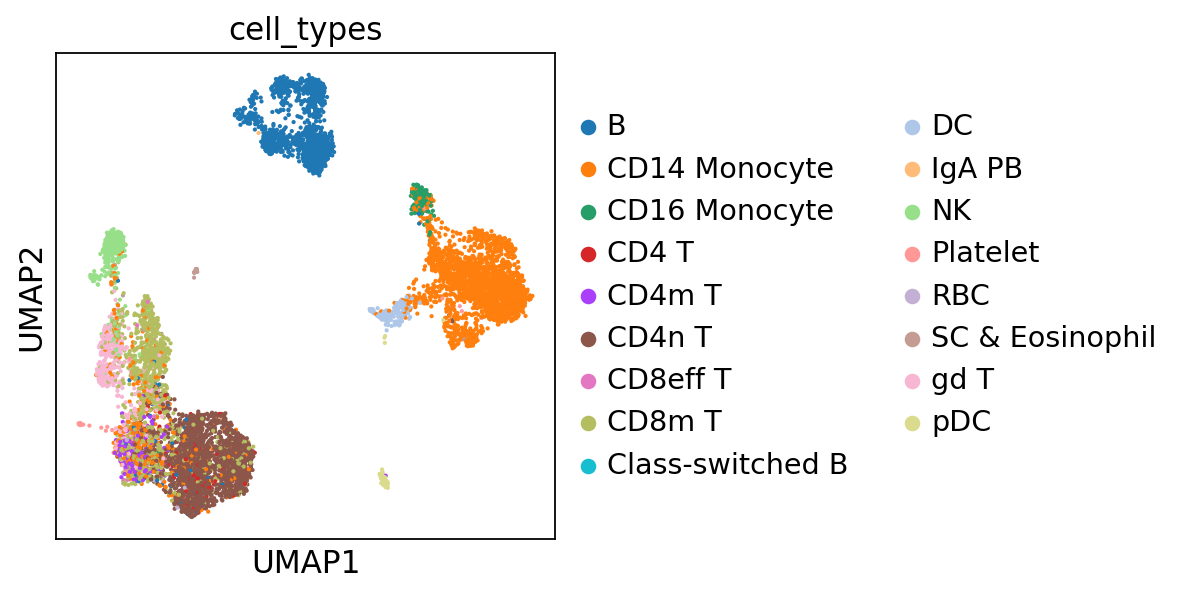

running Leiden clustering


    finished: found 12 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


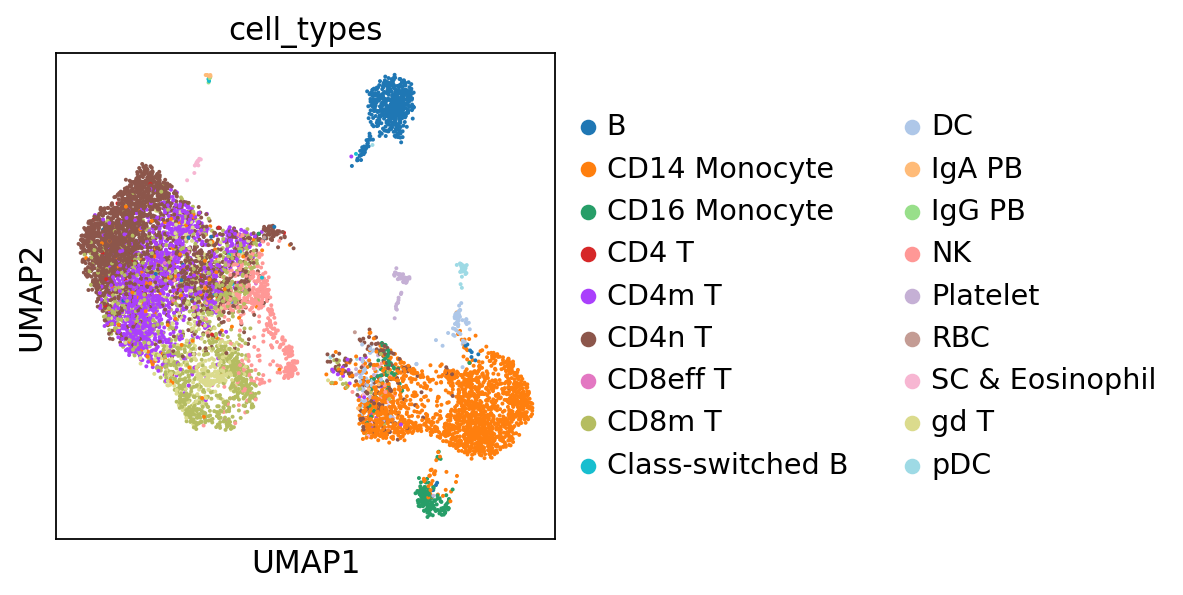

running Leiden clustering


    finished: found 10 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


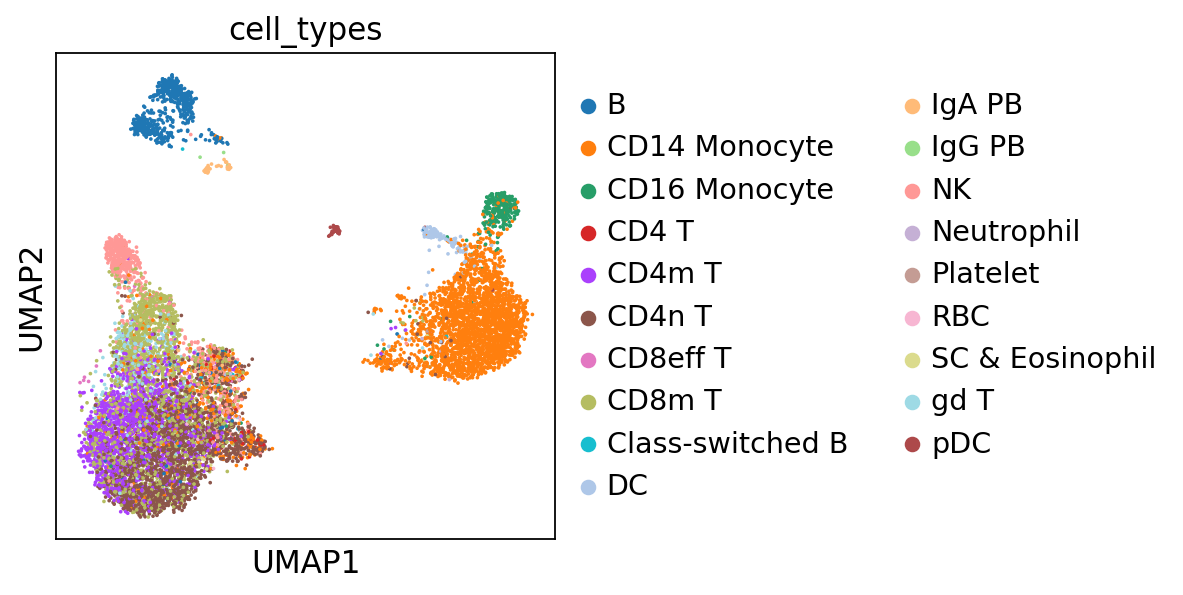

In [23]:
for adata in [adata_sc_bulk, adata_sc_ref, adata_sn]:
    sc.tl.leiden(adata, resolution=0.5)  # Louvain clustering
    sc.pl.umap(adata, color="cell_types")

## Fixing cell mapping to be more biologically relevant and broad:

In [24]:
# Define cell types to remove (make sure "NaN" is handled correctly)
cells_to_remove = [
    "Blood: Undefined",
    "NA",
    "SC & Eosinophil",
    "NaN",
]  # Remove "NaN" (not valid)

for i, adata in enumerate([adata_sc_bulk, adata_sc_ref, adata_sn]):
    # Remove cells with missing or unwanted types
    adata = adata[
        adata.obs["cell_types"].notna() & ~adata.obs["cell_types"].isin(cells_to_remove)
    ].copy()

    # Assign back to the original variable
    if i == 0:
        adata_sc_bulk = adata
    elif i == 1:
        adata_sc_ref = adata
    elif i == 2:
        adata_sn = adata

# Confirm that no missing values exist
print(f"SC Bulk missing cell types: {adata_sc_bulk.obs['cell_types'].isna().sum()}")
print(f"SC Ref missing cell types: {adata_sc_ref.obs['cell_types'].isna().sum()}")
print(f"SN missing cell types: {adata_sn.obs['cell_types'].isna().sum()}")

SC Bulk missing cell types: 0
SC Ref missing cell types: 0
SN missing cell types: 0


In [25]:
# Apply the mapping to the AnnData objects
for adata in [adata_sc_bulk, adata_sc_ref, adata_sn]:
    adata.obs["cell_types"] = adata.obs["cell_types"].map(cell_type_mapping).copy()

running Leiden clustering


    finished: found 11 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


... storing 'cell_types' as categorical


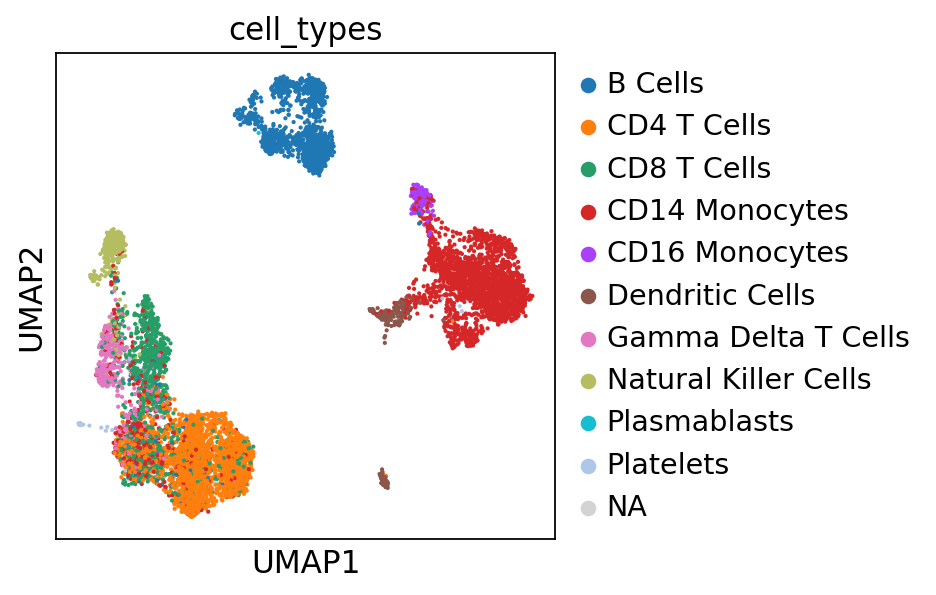

running Leiden clustering


    finished: found 11 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


... storing 'cell_types' as categorical


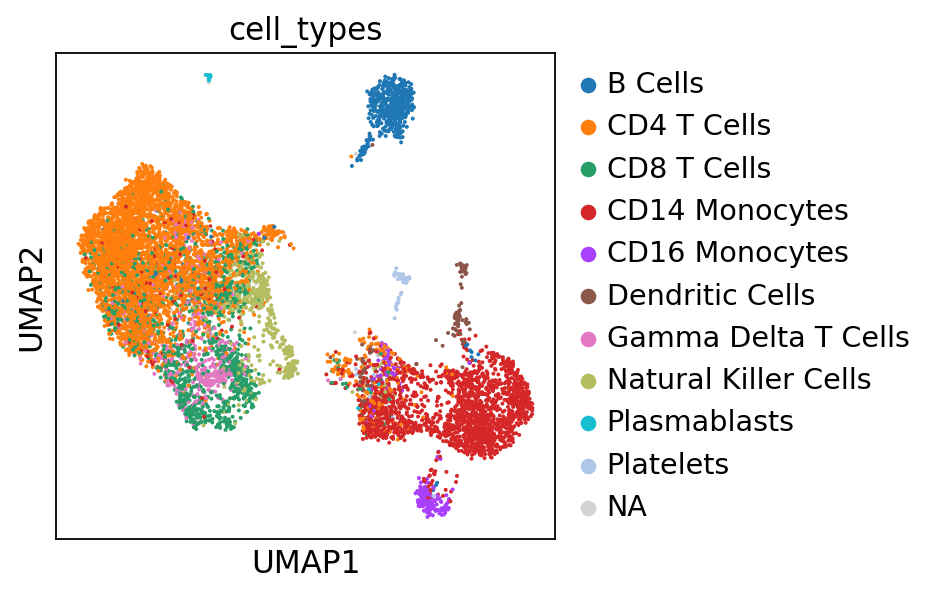

running Leiden clustering


    finished: found 9 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


... storing 'cell_types' as categorical


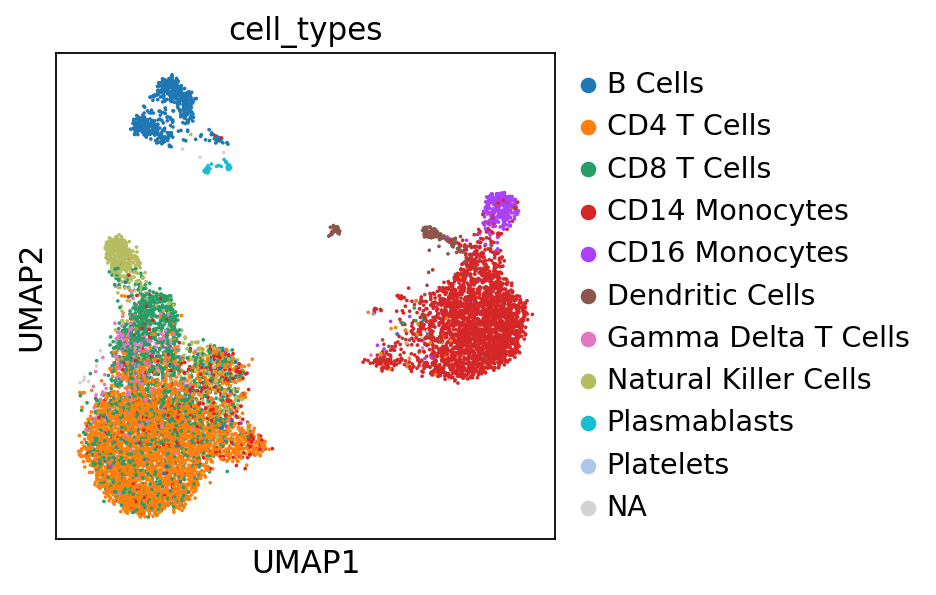

In [26]:
for adata in [adata_sc_bulk, adata_sc_ref, adata_sn]:
    sc.tl.leiden(adata, resolution=0.5)  # liden clustering to see cells again
    sc.pl.umap(adata, color="cell_types")

In [27]:
# Restore Raw Counts Before Saving
for adata in [adata_sc_bulk, adata_sc_ref, adata_sn]:
    print(adata)
    adata.X = adata.raw.X  # Restore original raw counts

AnnData object with n_obs × n_vars = 8361 × 33694
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score', 'cell_types'
    var: 'gene_ids', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'over_clustering', 'cell_types_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'
AnnData object with n_obs × n_vars = 9366 × 36601
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score', 'cell_types'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'di

In [28]:
for adata in [adata_sc_bulk, adata_sc_ref, adata_sn]:
    print(adata)
    print(adata.obs.cell_types.value_counts())  # Restore original raw counts
    adata = adata.obs_names_make_unique()

AnnData object with n_obs × n_vars = 8361 × 33694
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score', 'cell_types'
    var: 'gene_ids', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'over_clustering', 'cell_types_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'
cell_types
CD14 Monocytes          2471
CD4 T Cells             2305
B Cells                 1298
CD8 T Cells             1057
Gamma Delta T Cells      405
Natural Killer Cells     329
Dendritic Cells          199
CD16 Monocytes           126
Platelets                 29
Plasmablasts               1
Name: count, dtype: int64
AnnData object with n_obs × n_vars = 9366 × 36601
    obs: 'n_genes_by_counts

In [29]:
# Filtering the dataset that was not filtered before
if res_name == "MSB":
    adata_sn = adata_sn[adata_sn.obs.n_genes_by_counts < 7500, :]
    adata_sn = adata_sn[adata_sn.obs.pct_counts_mt < 35, :]
elif res_name == "PBMC":
    adata_sc_ref = adata_sc_ref[adata_sc_ref.obs.n_genes_by_counts < 5000, :]
    adata_sc_ref = adata_sc_ref[adata_sc_ref.obs.pct_counts_mt < 30, :]
else:
    ValueError('Not a valid data type res_name. Choose "MSB" or "PBMC"')

In [30]:
assert adata_sc_bulk.X.max() > 11
assert adata_sn.X.max() > 11
assert adata_sc_ref.X.max() > 11

In [31]:
# Save processed datasets
adata_sc_bulk.obs["deconvolution"] = "pseudobulks"
adata_sn.obs["deconvolution"] = "reference"
adata_sc_ref.obs["deconvolution"] = "reference"

adata_sc_bulk.obs["data_type"] = "single_cell"
adata_sn.obs["data_type"] = "single_nucleus"
adata_sc_ref.obs["data_type"] = "single_cell"

In [32]:
maps = {
    "dendritic cell": "Dendritic Cells",
    "endothelial cell": "Endothelial Cells",
    "immature NK T cell": "Immature NK T Cells",
    "monocyte": "Monocytes",
    "preadipocyte": "Preadipocytes",
    "T cell": "T Cells",
    "Endothelial cell": "Endothelial Cells",
    "T cell": "T Cells",
    "Macrophage": "Macrophages",
    "macrophage": "Macrophages",
    "Hepatocyte": "Hepatocytes",
    "Epithelial cell": "Epithelial Cells",
}
adata_sn.obs.cell_types = adata_sn.obs.cell_types.replace(maps)
adata_sc_ref.obs.cell_types = adata_sc_ref.obs.cell_types.replace(maps)
adata_sc_bulk.obs.cell_types = adata_sc_bulk.obs.cell_types.replace(maps)

In [33]:
path = f"{os.getcwd()}/../data/{res_name}/"  # Path to output
all_adatas = sc.concat([adata_sc_bulk, adata_sc_ref, adata_sn])
adata_path = os.path.join(path, f"sc_sn_{res_name}_processed.h5ad")
adata_path = Path(adata_path)
all_adatas.write_h5ad(adata_path)

... storing 'deconvolution' as categorical


... storing 'data_type' as categorical


Final QC

In [34]:
adata_sc_ref.obs.cell_types.value_counts()

cell_types
CD4 T Cells             3929
CD14 Monocytes          1882
CD8 T Cells             1215
B Cells                  521
Gamma Delta T Cells      457
Natural Killer Cells     382
CD16 Monocytes           181
Dendritic Cells          104
Platelets                 60
Plasmablasts              17
Name: count, dtype: int64

In [35]:
adata_sc_bulk.obs.cell_types.value_counts()

cell_types
CD14 Monocytes          2471
CD4 T Cells             2305
B Cells                 1298
CD8 T Cells             1057
Gamma Delta T Cells      405
Natural Killer Cells     329
Dendritic Cells          199
CD16 Monocytes           126
Platelets                 29
Plasmablasts               1
Name: count, dtype: int64

In [36]:
adata_sn.obs.cell_types.value_counts()

cell_types
CD4 T Cells             3792
CD14 Monocytes          2965
CD8 T Cells             1982
Natural Killer Cells     633
B Cells                  614
Gamma Delta T Cells      340
CD16 Monocytes           278
Dendritic Cells          184
Plasmablasts              45
Platelets                 11
Name: count, dtype: int64